### Summary
- Neural Network model used: Multilayer Perceptron
- 26 features extracted
- Accuracy: average 98% on unseen test data with 5-fold cross validation
- Parameters used: ~1500

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from glob import glob
from timeit import default_timer as timer
import sys
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneGridSearchCV

from keras.utils import np_utils,to_categorical
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
np.set_printoptions(threshold=100) # 'sys.maxsize' for max

The following section is modified from <code>extractDataset.py</code> which is written by **Sean Tan**. It performs data augmention on the raw dataset before segmenting individual dance move.

In [2]:
# modified from Sean's extractDataset.py

import sys
import os
import csv
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox, Button, RadioButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

from sklearn import preprocessing

# Definitions
BASEPATH = os.getcwd()
# SAVEFOLDER = ''
# TESTFOLDER = ''
DANCEMOVENAMES = ("dab","elbowkick","gun","hair","listen","pointhigh","sidepump","wipetable")
IS_RETURN_DATAFRAME = True

#Changeable Parameters
NUMBER_OF_AFTER_SAMPLES = 3 #Number of samples to include in dance move after end detected
NUMBER_OF_BEFORE_SAMPLES = 5 #Number of samples to include in dance move before start detected
MINIMUM_MOVE_TIME = 25 #Minimum number of samples to be considered a move. Set this too low and you will get garbage dance samples

IS_PAD = True
PAD_NUM =20

USE_MAX_SAMPLES = True
MAX_SAMPLES = 100
USETEMP = True
USEACCEL= True
TEMPORALDATAAUGNUM = 5
NUMRANDOMSHIFTSACCEL = 5
Z_RAND_MAX = 0.05


class rawDataset():
    def __init__(self, device, movename, timestamp, dataset):
        self.device = device
        self.movename = movename
        self.timestamp = timestamp
        self.dataset = dataset
    def plot(self):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.dataset['activation_List']))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("Device " + str(self.device) + "\nActivation" )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )


        ax1, = accel.plot(index, self.dataset['a_xList'], label = "X")
        ax2, = accel.plot(index, self.dataset['a_yList'], label = "Y")
        ax3, = accel.plot(index, self.dataset['a_zList'], label = "Z")

        ax4, = gyro.plot(index, self.dataset['g_xList'], label = "X")
        ax5, = gyro.plot(index, self.dataset['g_yList'], label = "Y")
        ax6, = gyro.plot(index, self.dataset['g_zList'], label = "Z")

        ax7, = activation.plot(index, self.dataset['activation_List'], label = "R")
        
        displaylen = len(self.dataset['activation_List'])

        activation.set_xlim(xmin = 0 , xmax = displaylen )
        activation.set_ylim(ymin = 0.2 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = displaylen )
        accel.set_ylim(ymin = -2 , ymax = 2 )

        gyro.set_xlim(xmin = 0 , xmax = displaylen )
        gyro.set_ylim(ymin = -250 , ymax = 250 )
        
        plt.show()

    
        plt.clf()


class dancemove():
    def __init__(self, device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List ):
        self.device = device
        self.movename = movename
        self.timestamp = timestamp

        self.a_xList = a_xList
        self.a_yList = a_yList
        self.a_zList = a_zList

        self.g_xList = g_xList
        self.g_yList = g_yList
        self.g_zList = g_zList
        
        self.activation_List = activation_List

    def toDict(self):
        d = dict()
        d['movename'] = self.movename
        d['a_xList'] = self.a_xList
        d['a_yList'] = self.a_yList
        d['a_zList'] = self.a_zList
        d['g_xList'] = self.g_xList
        d['g_yList'] = self.g_yList
        d['g_zList'] = self.g_zList
        d['activation_List'] = self.activation_List
        return d

    def writeThisFile(self,moveid):
        fname = "{}_{}_{}_{}".format(self.device, self.movename, self.timestamp, str(moveid))
        f = os.path.join(BASEPATH,PROCESSEDFOLDER,fname ) 
        if not os.path.exists(os.path.dirname(f)):
            try:
                os.makedirs(os.path.dirname(f))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        with open(f, 'w', newline='') as csvfile:
            row = [
                    'a_xList',
                    'a_yList',
                    'a_zList',
                    'g_xList',
                    'g_yList',
                    'g_zList',
                    'activation_List'
                ]
            csvWriter = csv.writer(csvfile, delimiter=',')
            csvWriter.writerow(row)
            for idx in range(len(self.a_xList)):
                row = [
                    self.a_xList[idx],
                    self.a_yList[idx],
                    self.a_zList[idx],
                    self.g_xList[idx],
                    self.g_yList[idx],
                    self.g_zList[idx],
                    self.activation_List[idx]
                ] 
                csvWriter.writerow(row)

    def plotNorm(self, show =True):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.activation_List))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("{} {} {}".format(self.device, self.movename, self.timestamp) )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )
        # print( self.a_xList)

        d = self.getDataAsNumpyArray( norm = True)
        ax1, = accel.plot(index, d[0], label = "X")
        ax2, = accel.plot(index, d[1], label = "Y")
        ax3, = accel.plot(index, d[2], label = "Z")

        ax4, = gyro.plot(index, d[3], label = "X")
        ax5, = gyro.plot(index, d[4], label = "Y")
        ax6, = gyro.plot(index, d[5], label = "Z")

        ax7, = activation.plot(index, self.activation_List, label = "R")
        

        activation.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        activation.set_ylim(ymin = 0 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        accel.set_ylim(ymin = 0 , ymax = 1.1 )

        gyro.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        gyro.set_ylim(ymin = 0 , ymax = 1.1 )

        if show:
            plt.show(block = True)
            plt.clf()

    def plot(self, show =True):
        fig = plt.figure()
        gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[0.2,1,1])
        index = [ x for x in range(len(self.activation_List))]
        # print(index)
        # TODO plot the activation
        activation = fig.add_subplot(gs[0])
        accel = fig.add_subplot(gs[1])
        gyro = fig.add_subplot(gs[2])

        activation.set_title("{} {} {}".format(self.device, self.movename, self.timestamp) )
        accel.set_title("Accel" )
        gyro.set_title("Gyro" )
        # print( self.a_xList)

        ax1, = accel.plot(index, self.a_xList, label = "X")
        ax2, = accel.plot(index, self.a_yList, label = "Y")
        ax3, = accel.plot(index, self.a_zList, label = "Z")

        ax4, = gyro.plot(index, self.g_xList, label = "X")
        ax5, = gyro.plot(index, self.g_yList, label = "Y")
        ax6, = gyro.plot(index, self.g_zList, label = "Z")

        ax7, = activation.plot(index, self.activation_List, label = "R")
        

        activation.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        activation.set_ylim(ymin = 0.2 , ymax = 2.2 )

        accel.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        accel.set_ylim(ymin = -2 , ymax = 2 )

        gyro.set_xlim(xmin = 0 , xmax = len(self.activation_List) )
        gyro.set_ylim(ymin = -250 , ymax = 250 )

        if show:
            plt.show(block = True)
            plt.clf()

    def print_Data(self):
        print(self.activation_List)

    def get_label(self):
        return self.movename

    def get_data(self):
        return [
            self.a_xList,
            self.a_yList,
            self.a_zList,
            self.g_xList,
            self.g_yList,
            self.g_zList,
            self.activation_List
        ] 

    def get_data_len(self):
        mydata = self.get_data()
        assert all(len(x)==len(mydata[0]) for x in mydata)
        return len(mydata[0])

    
    
    def getDataAsNumpyArray(self, norm = True):
            x = np.array(self.a_xList)
            y = np.array(self.a_yList)
            z = np.array(self.a_zList)
            x2 = np.array(self.g_xList)
            y2 = np.array(self.g_yList)
            z2 = np.array(self.g_zList)
            a = np.array(self.activation_List)

            if norm:
                NormLimit = 1
                x = (x+2)/4 * NormLimit
                y = (y+2)/4 * NormLimit
                z = (z+2)/4 * NormLimit

                x2 = (x2+250)/ (250 * 2) * NormLimit
                y2 = (y2+250)/ (250 * 2) * NormLimit
                z2 = (z2+250)/ (250 * 2) * NormLimit

                x = np.clip(x,0,NormLimit)
                y = np.clip(y,0,NormLimit)
                z = np.clip(z,0,NormLimit)

                x2 = np.clip(x2,0,NormLimit)
                y2 = np.clip(y2,0,NormLimit)
                z2 = np.clip(z2,0,NormLimit)

            
            f = [x,y,z,x2,y2,z2]
            return np.array(f)


def listFiles(savepath):
    filepath = os.path.join(BASEPATH, savepath)
    return os.listdir(filepath)

def extractFileMetadata(fname):
    device, movename, timestamp = fname.split("_")
    return (device, movename, timestamp)

def readRawDataset(fname, savepath):
    filepath = os.path.join(BASEPATH, savepath, fname)

    dataset = {
        'a_xList': [],
        'a_yList': [],
        'a_zList': [],
        'g_xList': [],
        'g_yList': [],
        'g_zList': [],
        'activation_List': []
    }
    with open(filepath, 'r', newline='') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        count = 0
        for row in csvReader:
            # print(row)
            if count == 0:
                count += 1
                continue
            dataset['a_xList'].append(float(row[0]))
            dataset['a_yList'].append(float(row[1]))
            dataset['a_zList'].append(float(row[2]))
            dataset['g_xList'].append(float(row[3]))
            dataset['g_yList'].append(float(row[4]))
            dataset['g_zList'].append(float(row[5]))
            dataset['activation_List'].append(int(row[6]))
            count += 1
        if IS_PAD:
            for i in range(PAD_NUM):
                dataset['a_xList'].insert(0,dataset['a_xList'][0])
                dataset['a_yList'].insert(0,dataset['a_yList'][0])
                dataset['a_zList'].insert(0,dataset['a_zList'][0])
                dataset['g_xList'].insert(0,dataset['g_xList'][0])
                dataset['g_yList'].insert(0,dataset['g_yList'][0])
                dataset['g_zList'].insert(0,dataset['g_zList'][0])
                dataset['activation_List'].insert(0,dataset['activation_List'][0])

                dataset['a_xList'].append(dataset['a_xList'][-1])
                dataset['a_yList'].append(dataset['a_yList'][-1])
                dataset['a_zList'].append(dataset['a_zList'][-1])
                dataset['g_xList'].append(dataset['g_xList'][-1])
                dataset['g_yList'].append(dataset['g_yList'][-1])
                dataset['g_zList'].append(dataset['g_zList'][-1])
                dataset['activation_List'].append(dataset['activation_List'][-1])


        device, movename, timestamp = extractFileMetadata(fname)
        print("Recording from {} with move {} at {} opened with {} samples".format(device, movename,timestamp ,count - 1))

        r = rawDataset(device, movename, timestamp, dataset)
        return r

def isolateSequences(rawdata, useAccelBaseValueAugmentation =True , useTemporalAugmentation =True):
    moveIdxs = []
    device = rawdata.device
    movename = rawdata.movename
    timestamp = rawdata.timestamp
    d = rawdata.dataset

    numberOfSamples = len(d['a_xList'])
    isInMove=False
    startIdx = None
    endIdx = None
    for idx in range(numberOfSamples):
        currentActivation = d['activation_List'][idx]
        if (currentActivation == 2) and (isInMove == False):
            isInMove = True
            startIdx = idx
            cooldown = MINIMUM_MOVE_TIME
        elif (isInMove == True) and (not currentActivation == 2):
            isInMove = False
            endIdx = idx
            moveIdxs.append( (startIdx,endIdx ) )

    movesData = []
    for start,end in moveIdxs:
        
        if (end - start) < MINIMUM_MOVE_TIME:
            continue

        if USE_MAX_SAMPLES:
            if useTemporalAugmentation:
                for i in range(-TEMPORALDATAAUGNUM*2,(TEMPORALDATAAUGNUM+1)*2,2 ):
                    localStart = start - NUMBER_OF_BEFORE_SAMPLES
                    requiresPad = 0
                    if localStart<0:
                        requiresPad = abs(localStart)
                        localStart = 0
                    localEnd = localStart + MAX_SAMPLES
                    a_xList = d['a_xList'][localStart+i:localEnd+i]
                    a_yList = d['a_yList'][localStart+i:localEnd+i]
                    a_zList = d['a_zList'][localStart+i:localEnd+i]
                    g_xList = d['g_xList'][localStart+i:localEnd+i]
                    g_yList = d['g_yList'][localStart+i:localEnd+i]
                    g_zList = d['g_zList'][localStart+i:localEnd+i]
                    activation_List = d['activation_List'][localStart+i:localEnd+i]

                    if len(a_xList)==0:
                        print("DATAERROR")
                        print(len(a_xList),len(a_yList),len(a_zList),len(g_xList),len(g_yList),len(g_zList) )
                        print(len(d['a_xList']),len( d['a_yList']),len(d['a_zList']),len(d['g_xList']),len(d['g_yList']),len(d['g_zList']) )
                        print(localStart+i,localEnd+i)

                        assert False
                    dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                    movesData.append(dm)
                    
                if useAccelBaseValueAugmentation:
                    for i in range(NUMRANDOMSHIFTSACCEL):
                        localStart = start - NUMBER_OF_BEFORE_SAMPLES
                        localEnd = localStart + MAX_SAMPLES
                        z_rand = random.uniform(0, Z_RAND_MAX)
                        y_rand = random.uniform(0, z_rand)
                        x_rand = z_rand - y_rand
                        a_xList = list( map( lambda x: x + x_rand, a_xList) )
                        a_yList = list( map( lambda x: x + y_rand, a_yList) )
                        a_zList = list( map( lambda x: x - z_rand, a_zList) )
                        # g_xList = d['g_xList'][localStart:localEnd]
                        # g_yList = d['g_yList'][localStart:localEnd]
                        # g_zList = d['g_zList'][localStart:localEnd]
                        # activation_List = d['activation_List'][localStart:localEnd]
                        dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                        movesData.append(dm)

            if not useAccelBaseValueAugmentation and not useTemporalAugmentation:
                    localStart = start - NUMBER_OF_BEFORE_SAMPLES
                    localEnd = localStart + MAX_SAMPLES
                    a_xList = d['a_xList'][localStart:localEnd]
                    a_yList = d['a_yList'][localStart:localEnd]
                    a_zList = d['a_zList'][localStart:localEnd]
                    g_xList = d['g_xList'][localStart:localEnd]
                    g_yList = d['g_yList'][localStart:localEnd]
                    g_zList = d['g_zList'][localStart:localEnd]
                    activation_List = d['activation_List'][localStart:localEnd]
                    dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
                    movesData.append(dm)

        else:
            a_xList = d['a_xList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            a_yList = d['a_yList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            a_zList = d['a_zList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_xList = d['g_xList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_yList = d['g_yList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            g_zList = d['g_zList'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]
            activation_List = d['activation_List'][start - NUMBER_OF_BEFORE_SAMPLES: end + NUMBER_OF_AFTER_SAMPLES ]


            dm = dancemove(device, movename, timestamp,a_xList,a_yList,a_zList,g_xList,g_yList,g_zList,activation_List)
            movesData.append(dm)
    return movesData



def processData(dancer, testset=False):
    
    if not testset:
        SAVEFOLDER = 'dataset/raw/train/' + dancer
        raws = list(map(lambda x:readRawDataset(x, SAVEFOLDER), listFiles(SAVEFOLDER)))
    else:
        TESTFOLDER = 'dataset/raw/test/' + dancer
        raws = list(map(lambda x:readRawDataset(x ,savepath= TESTFOLDER), listFiles(savepath= TESTFOLDER)))

    combinedList = []
    numberOfMoves = 0
    for item in raws:
        # item.plot()
        moves = isolateSequences(item, useTemporalAugmentation = USETEMP, useAccelBaseValueAugmentation= USEACCEL )
        numberOfMoves += len(moves)
        combinedList.extend(moves)
    print("Done")
    print("Extracted {} moves from {} raw data Sequences.".format(numberOfMoves, len(raws)))

    numberOfEachMoves = dict.fromkeys(DANCEMOVENAMES ,0)
    numberOfEachMoves["defaultMove"] = 0
    for item in combinedList:
        numberOfEachMoves[item.movename] += 1
        
    for k,v in numberOfEachMoves.items():
        print("{}  {}".format(v, k))

    # for item in combinedList:
    #     item.plot()

#     for idx,item in enumerate(combinedList):
#         item.writeThisFile(idx)   
  
    if IS_RETURN_DATAFRAME:
        frame = pd.DataFrame()
        c = list(map(lambda x : x.toDict(),combinedList ))
        for df in c:
            frame = frame.append(df, ignore_index=True)
        return frame

    return combinedList

### Generate training and test dataset

In [ ]:
# dancers = ['Alex', 'Abi', 'CJ', 'Ryan', 'XY']

In [3]:
train_dancers = ['Abi', 'Ryan', 'Alex', 'XY', 'Sean', 'CJ']
test_dancers = ['Alex', 'XY', 'Sean']

In [4]:
def dancer_data_train(dancers):
    df = pd.DataFrame()
    for dancer in dancers:
        print("\nProcessing {}'s dance moves as training set:" .format(dancer))
        df_temp = processData(dancer, testset=False)
        df_temp['Dancer'] = dancer
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df

def dancer_data_test(dancers):
    df = pd.DataFrame()
    for dancer in dancers:
        print("\nProcessing {}'s dance moves as test set:" .format(dancer))
        df_temp = processData(dancer, testset=True)
        df_temp['Dancer'] = dancer
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df

In [6]:
dance_move_training = dancer_data_train(train_dancers)


Processing Abi's dance moves as training set:
Recording from dev2 with move pointhigh at 16177872911030 opened with 490 samples
Recording from dev2 with move elbowkick at 16177865938445 opened with 485 samples
Recording from dev2 with move hair at 16177868198639 opened with 490 samples
Recording from dev2 with move wipetable at 16177877081388 opened with 527 samples
Recording from dev2 with move wipetable at 16177877441793 opened with 560 samples
Recording from dev2 with move sidepump at 16177875370894 opened with 584 samples
Recording from dev2 with move wipetable at 16177876791034 opened with 577 samples
Recording from dev2 with move hair at 16177869064094 opened with 522 samples
Recording from dev2 with move dab at 16177863472947 opened with 503 samples
Recording from dev2 with move pointhigh at 16177872203653 opened with 493 samples
Recording from dev2 with move gun at 16177866728850 opened with 527 samples
Recording from dev2 with move listen at 16177870147162 opened with 677 sam


Processing XY's dance moves as training set:
Recording from dev2 with move gun at 16177853197850 opened with 453 samples
Recording from dev2 with move pointhigh at 16177856100146 opened with 477 samples
Recording from dev2 with move elbowkick at 16177850856827 opened with 475 samples
Recording from dev2 with move sidepump at 16177857718604 opened with 419 samples
Recording from dev2 with move elbowkick at 16177850558064 opened with 495 samples
Recording from dev2 with move gun at 16177852956346 opened with 416 samples
Recording from dev2 with move hair at 16177854287446 opened with 424 samples
Recording from dev2 with move sidepump at 16177857490450 opened with 431 samples
Recording from dev2 with move wipetable at 16177858854348 opened with 403 samples
Recording from dev2 with move wipetable at 16177859070427 opened with 408 samples
Recording from dev2 with move elbowkick at 16177851665931 opened with 391 samples
Recording from dev2 with move gun at 16177852238158 opened with 448 sam

Recording from dev3 with move dab at 16176145200147 opened with 630 samples
Recording from dev3 with move sidepump at 16176167243143 opened with 492 samples
Recording from dev3 with move wipetable at 16176170420438 opened with 481 samples
Recording from dev2 with move hair at 16176160779452 opened with 485 samples
Recording from dev2 with move wipetable at 16176170779258 opened with 642 samples
Recording from dev1 with move dab at 16176145899309 opened with 665 samples
Recording from dev2 with move pointhigh at 16176164190205 opened with 388 samples
Recording from dev2 with move sidepump at 16176166959248 opened with 530 samples
Recording from dev1 with move listen at 16176163217094 opened with 495 samples
Recording from dev3 with move gun at 16176158289634 opened with 503 samples
Recording from dev1 with move hair at 16176160231052 opened with 547 samples
Recording from dev3 with move wipetable at 16176173617076 opened with 435 samples
Recording from dev2 with move gun at 161761557157

In [8]:
dance_move_training

,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename,Dancer
0,"[0.42121777651274916, 0.4214806659076495, 0.41...","[-0.024214552864462315, -0.02077873171867739, ...","[-0.9531249818069045, -0.9531249890841427, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, -1.953125, -3.90625, -3.90625, -3.90625,...","[-1.953125, 0.0, 0.0, -1.953125, -1.953125, -1...","[-1.953125, 1.953125, 1.953125, -1.953125, -5....",pointhigh,Abi
1,"[0.4153883995445897, 0.4117330397267538, 0.415...","[-0.018717239031206433, -0.023730343418723862,...","[-0.9531249934504855, -0.9531249960702912, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[-3.90625, -3.90625, -3.90625, -3.90625, -1.95...","[0.0, -1.953125, -1.953125, -1.953125, 0.0, 0....","[1.953125, -1.953125, -5.859375, -3.90625, -3....",pointhigh,Abi
2,"[0.4157898238360523, 0.41822389430163137, 0.41...","[-0.026738206051234316, -0.02854292363074059, ...","[-0.9593749976421748, -0.963124998585305, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[-3.90625, -3.90625, -1.953125, -1.953125, 0.0...","[-1.953125, -1.953125, 0.0, 0.0, 0.0, 0.0, 0.0...","[-5.859375, -3.90625, -3.90625, -5.859375, -3....",pointhigh,Abi
3,"[0.4196843365809788, 0.4205606019485873, 0.421...","[-0.029625754178444354, -0.030275452507066612,...","[-0.959124999151183, -0.9567249994907099, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[-1.953125, -1.953125, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.765625,...","[-3.90625, -5.859375, -3.90625, -1.953125, -1....",pointhigh,Abi
4,"[0.4210863611691524, 0.4214018167014914, 0.421...","[-0.024415271504239965, -0.020899162902543976,...","[-0.961534999694426, -0.9581709998166557, -0.9...","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.859375, 52.734375,...","[0.0, 0.0, 0.0, 0.0, 0.0, -9.765625, 1.953125,...","[-3.90625, -1.953125, -1.953125, -1.953125, 0....",pointhigh,Abi
...,...,...,...,...,...,...,...,...,...
7515,"[0.4446221796286952, 0.44602112682869366, 0.40...","[-1.1032052793576803, -1.1299327156771468, -1....","[-0.7378045099698493, -0.6914209769708476, -0....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ
7516,"[0.460900832172522, 0.4622997793725204, 0.4193...","[-1.0978339155353196, -1.1245613518547861, -1....","[-0.7594545263360367, -0.713070993337035, -0.5...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ
7517,"[0.48468630070430796, 0.4860852479043064, 0.44...","[-1.0771209308969136, -1.1038483672163801, -0....","[-0.8039529795062287, -0.757569446507227, -0.6...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ
7518,"[0.4884514018189595, 0.48985034901895796, 0.44...","[-1.0767709264667942, -1.1034983627862607, -0....","[-0.8080680850509997, -0.761684552051998, -0.6...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[248.046875, 248.046875, 248.046875, 248.04687...","[-60.546875, -76.171875, -52.734375, -74.21875...","[46.875, 31.25, 3.90625, -19.53125, -25.390625...",dab,CJ


In [7]:
dance_move_testing = dancer_data_test(test_dancers)


Processing Alex's dance moves as test set:
Recording from dev1 with move pointhigh at 16176184173502 opened with 356 samples
Recording from dev1 with move pointhigh at 16176183962263 opened with 374 samples
Recording from dev1 with move elbowkick at 16176180261757 opened with 449 samples
Recording from dev1 with move sidepump at 16176184509627 opened with 381 samples
Recording from dev1 with move pointhigh at 16176183743580 opened with 364 samples
Recording from dev1 with move wipetable at 16176186333797 opened with 401 samples
Recording from dev1 with move gun at 16176181423839 opened with 385 samples
Recording from dev1 with move wipetable at 16176186098233 opened with 384 samples
Recording from dev1 with move dab at 16176179158421 opened with 371 samples
Recording from dev1 with move wipetable at 16176185868602 opened with 343 samples
Recording from dev1 with move elbowkick at 16176180761776 opened with 401 samples
Recording from dev1 with move sidepump at 16176184957990 opened wit

In [9]:
dance_move_testing

,a_xList,a_yList,a_zList,activation_List,g_xList,g_yList,g_zList,movename,Dancer
0,"[0.46849149001213014, 0.46859489400727805, 0.4...","[-0.3557597384462116, -0.350955843067727, -0.3...","[-0.8906109411964822, -0.8906165647178894, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, -1.953125, -1.953125, -1.95312...","[0.0, 0.0, -1.953125, -1.953125, -1.953125, -1...","[1.953125, 1.953125, 0.0, -1.953125, 0.0, 0.0,...",pointhigh,Alex
1,"[0.46865693640436684, 0.4686941618426201, 0.46...","[-0.34807350584063623, -0.3463441035043817, -0...","[-0.8906199388307336, -0.8906219632984402, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[0.0, -1.953125, -1.953125, -1.953125, -1.9531...","[-1.953125, -1.953125, -1.953125, -1.953125, -...","[0.0, -1.953125, 0.0, 0.0, 0.0, 5.859375, 7.81...",pointhigh,Alex
2,"[0.46871649710557206, 0.46247989826334324, 0.4...","[-0.35155646210262903, -0.34843387726157743, -...","[-0.8906231779790641, -0.8906239067874384, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...","[-1.953125, -1.953125, -1.953125, -3.90625, 1....","[-1.953125, -1.953125, -1.953125, 1.953125, 0....","[0.0, 0.0, 0.0, 5.859375, 7.8125, 9.765625, 0....",pointhigh,Alex
3,"[0.46498793895800594, 0.4602427633748036, 0.43...","[-0.3528103263569465, -0.36168619581416794, -0...","[-0.896874344072463, -0.9006246064434779, -0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[-1.953125, -3.90625, 1.953125, 11.71875, 21.4...","[-1.953125, 1.953125, 0.0, -1.953125, 5.859375...","[0.0, 5.859375, 7.8125, 9.765625, 0.0, 46.875,...",pointhigh,Alex
4,"[0.4386456580248821, 0.41943739481492925, 0.42...","[-0.37951171748850077, -0.39645703049310044, -...","[-0.9028747638660868, -0.904224858319652, -0.9...","[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1.953125, 11.71875, 21.484375, 19.53125, 27.3...","[0.0, -1.953125, 5.859375, 9.765625, 33.203125...","[7.8125, 9.765625, 0.0, 46.875, 58.59375, 76.1...",pointhigh,Alex
...,...,...,...,...,...,...,...,...,...
2123,"[0.3267770515156984, 0.3526800073810417, 0.449...","[-1.760231388859116, -1.8302836685718669, -1.7...","[-0.7980802647578101, -0.9550671000699112, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[115.234375, 224.609375, 248.046875, 248.04687...","[-39.0625, -54.6875, -119.140625, -148.4375, -...","[3.90625, 123.046875, 164.0625, 128.90625, 23....",gun,Sean
2124,"[0.33282701009721843, 0.35872996596256174, 0.4...","[-1.723410785012442, -1.793463064725193, -1.67...","[-0.840950827186004, -0.9979376624981051, -1.2...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[115.234375, 224.609375, 248.046875, 248.04687...","[-39.0625, -54.6875, -119.140625, -148.4375, -...","[3.90625, 123.046875, 164.0625, 128.90625, 23....",gun,Sean
2125,"[0.3543966848101596, 0.3802996406755029, 0.477...","[-1.7011142115700773, -1.7711664912828282, -1....","[-0.8848170753413099, -1.0418039106534112, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[115.234375, 224.609375, 248.046875, 248.04687...","[-39.0625, -54.6875, -119.140625, -148.4375, -...","[3.90625, 123.046875, 164.0625, 128.90625, 23....",gun,Sean
2126,"[0.39810157576297517, 0.42400453162831847, 0.5...","[-1.6998483784499132, -1.7699006581626642, -1....","[-0.9297877994142895, -1.0867746347263907, -1....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[115.234375, 224.609375, 248.046875, 248.04687...","[-39.0625, -54.6875, -119.140625, -148.4375, -...","[3.90625, 123.046875, 164.0625, 128.90625, 23....",gun,Sean


In [10]:
import statistics
from spectrum import aryule
from scipy.stats import pearsonr
from scipy.stats import entropy
from math import sqrt
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis
from scipy.stats import skew

In [11]:
features_train = pd.DataFrame()
features_test = pd.DataFrame()

In [12]:
def get_mean(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.mean(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def get_std(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.std(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T

def get_ptp(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.ptp(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T

def fourier_transform(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(np.fft.fft(xyz_acc_mean.values[row][col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def get_mag(val):
    data = []
    for i in range(len(val)):
        x, y, z = val.values[i]
        data.append(sqrt(pow(x, 2) + pow(y, 2) + pow(z, 2)))
    return np.array(data).T


def get_kurtosis(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(kurtosis(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T


def get_skew(x):
    data = []
    data_temp = []
    for col in range(x.shape[1]):
        for row in range(x.shape[0]):
            data_temp.append(skew(x.iloc[row, col]))
            if row == x.shape[0]-1:
                data.append(data_temp)
                data_temp = []
    return np.array(data).T 

In [16]:
def extract_features(dataset):
    xyz_acc = dataset.iloc[0:, 0:3]
    xyz_gyro = dataset.iloc[0:, 4:7]
    dancer = dataset.iloc[0:, 8]
    move = dataset.iloc[0:, 7]
    xyz_acc_mean = pd.DataFrame(get_mean(xyz_acc), columns=['acc_X_mean', 'acc_Y_mean', 'acc_Z_mean'])
    xyz_acc_std = pd.DataFrame(get_std(xyz_acc), columns=['acc_X_std', 'acc_Y_std', 'acc_Z_std'])
    xyz_acc_mag = pd.DataFrame(get_mag(xyz_acc_mean), columns=['acc_mag'])
    xyz_acc_kurtosis = pd.DataFrame(get_kurtosis(xyz_acc), columns=['acc_X_kurtosis', 'acc_Y_kurtosis', 'acc_Z_kurtosis'])
    xyz_acc_skew = pd.DataFrame(get_skew(xyz_acc), columns=['acc_X_skew', 'acc_Y_skew', 'acc_Z_skew'])
    xyz_acc_ptp = pd.DataFrame(get_ptp(xyz_acc), columns=['acc_X_ptp', 'acc_Y_ptp', 'acc_Z_ptp'])
    
    xyz_gyro_mean = pd.DataFrame(get_mean(xyz_gyro), columns=['gyro_X_mean', 'gyro_Y_mean', 'gyro_Z_mean'])
    xyz_gyro_std = pd.DataFrame(get_std(xyz_gyro), columns=['gyro_X_std', 'gyro_Y_std', 'gyro_Z_std'])
    xyz_gyro_mag = pd.DataFrame(get_mag(xyz_gyro_mean), columns=['gyro_mag'])
    xyz_gyro_kurtosis = pd.DataFrame(get_kurtosis(xyz_gyro), columns=['gyro_X_kurtosis', 'gyro_Y_kurtosis', 'gyro_Z_kurtosis'])
    xyz_gyro_skew = pd.DataFrame(get_skew(xyz_gyro), columns=['gyro_X_skew', 'gyro_Y_skew', 'gyro_Z_skew'])
    xyz_gyro_ptp = pd.DataFrame(get_ptp(xyz_gyro), columns=['gyro_X_ptp', 'gyro_Y_ptp', 'gyro_Z_ptp'])
    
    extracted_features = pd.concat([xyz_acc_mean, xyz_acc_std, xyz_acc_mag, xyz_acc_ptp,
                                    xyz_acc_kurtosis, xyz_acc_skew,
                                    xyz_gyro_mean, xyz_gyro_std, xyz_gyro_mag, xyz_gyro_ptp,
                                    xyz_gyro_kurtosis, xyz_gyro_skew,
                                    dancer, move], axis=1)
    return extracted_features

In [17]:
extracted_features_training = extract_features(dance_move_training)

In [18]:
extracted_features_training

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_ptp,acc_Y_ptp,acc_Z_ptp,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_ptp,gyro_Y_ptp,gyro_Z_ptp,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew,Dancer,movename
0,0.397146,-0.562035,-0.090921,0.352147,0.603819,0.583344,0.694172,1.515083,2.282805,2.154588,-0.017364,-0.099377,-0.609993,0.641825,-1.045827,-0.820389,26.074219,4.785156,19.121094,133.403549,108.309675,80.804770,32.686065,498.046875,455.078125,406.250000,-0.399728,-0.065306,0.266540,-0.163037,0.622833,-0.516494,Abi,pointhigh
1,0.388723,-0.568720,-0.065219,0.356479,0.599689,0.573015,0.691955,1.515083,2.282805,2.154588,-0.069715,-0.078825,-0.375763,0.661981,-1.047755,-0.923977,21.738281,1.054688,21.425781,137.742721,111.647165,81.900219,30.540618,498.046875,457.031250,406.250000,-0.522552,-0.143086,0.197331,-0.170268,0.562913,-0.544658,Abi,pointhigh
2,0.385703,-0.585452,-0.049191,0.357395,0.596643,0.559628,0.702809,1.515083,2.282805,2.154588,-0.074339,-0.144688,-0.132110,0.678411,-1.001381,-0.999078,16.816406,-2.539062,22.226562,142.872367,114.678379,82.077638,27.986755,498.046875,472.656250,406.250000,-0.630788,-0.203322,0.193871,-0.186680,0.519951,-0.566568,Abi,pointhigh
3,0.390390,-0.612550,-0.041196,0.359419,0.601550,0.549348,0.727543,1.515083,2.282805,2.154588,-0.165933,-0.361472,0.011115,0.637339,-0.905736,-1.025057,13.085938,-3.964844,21.679688,145.771050,115.257696,83.342615,25.631438,498.046875,472.656250,406.250000,-0.751830,-0.224158,0.081491,-0.156424,0.539761,-0.572913,Abi,pointhigh
4,0.396141,-0.646668,-0.035331,0.362183,0.615803,0.541040,0.759181,1.515083,2.282805,2.154588,-0.277481,-0.587958,0.115395,0.589303,-0.817213,-1.038956,12.675781,-6.113281,22.460938,146.189676,116.162725,83.484386,26.505497,498.046875,472.656250,406.250000,-0.776320,-0.256960,0.084127,-0.150402,0.568545,-0.595087,Abi,pointhigh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,0.664906,-0.567131,-0.065321,0.397714,0.483585,0.498473,0.876358,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab
7516,0.681184,-0.561759,-0.086971,0.397714,0.483585,0.498473,0.887215,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab
7517,0.704970,-0.541046,-0.131470,0.397714,0.483585,0.498473,0.898331,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab
7518,0.708735,-0.540696,-0.135585,0.397714,0.483585,0.498473,0.901688,1.789977,2.009130,2.315979,0.434379,-0.763264,0.188821,0.707005,-0.301526,-0.654990,3.671875,14.121094,-15.429688,134.023170,124.131152,97.911191,21.235894,498.046875,498.046875,498.046875,-0.435295,-0.082573,0.608774,0.248793,-0.040304,-0.433629,CJ,dab


In [19]:
extracted_features_testing = extract_features(dance_move_testing)

In [20]:
extracted_features_testing

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_std,acc_Y_std,acc_Z_std,acc_mag,acc_X_ptp,acc_Y_ptp,acc_Z_ptp,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_skew,acc_Y_skew,acc_Z_skew,gyro_X_mean,gyro_Y_mean,gyro_Z_mean,gyro_X_std,gyro_Y_std,gyro_Z_std,gyro_mag,gyro_X_ptp,gyro_Y_ptp,gyro_Z_ptp,gyro_X_kurtosis,gyro_Y_kurtosis,gyro_Z_kurtosis,gyro_X_skew,gyro_Y_skew,gyro_Z_skew,Dancer,movename
0,0.284872,-0.642226,0.238160,0.363173,0.568941,0.603257,0.741840,1.500347,2.197390,2.041789,-0.526981,-0.699802,-0.438876,0.160311,-0.648430,-0.815113,14.003906,6.562500,4.960938,113.559752,101.395415,79.644127,16.241512,484.375000,488.281250,333.984375,-0.054065,0.419663,-0.444639,0.240724,0.590680,-0.346096,Alex,pointhigh
1,0.284516,-0.663751,0.271837,0.363016,0.578027,0.586166,0.771629,1.500347,2.197390,2.041789,-0.522408,-0.860246,-0.196754,0.162884,-0.561501,-0.900226,16.953125,4.765625,6.406250,115.076653,102.395666,80.234261,18.739255,484.375000,488.281250,333.984375,-0.191269,0.355628,-0.482020,0.186506,0.603562,-0.379422,Alex,pointhigh
2,0.283388,-0.670776,0.302299,0.362539,0.577004,0.564218,0.788437,1.500347,2.197390,2.041789,-0.508237,-0.873241,0.105795,0.171169,-0.531737,-0.990785,18.281250,4.941406,4.902344,115.274927,102.393854,81.063156,19.561559,484.375000,488.281250,333.984375,-0.217224,0.351738,-0.588080,0.153197,0.598453,-0.333684,Alex,pointhigh
3,0.281320,-0.667217,0.327603,0.361789,0.579566,0.538010,0.794759,1.500347,2.197390,2.041789,-0.484683,-0.887849,0.460496,0.187044,-0.533324,-1.065724,17.421875,4.960938,4.121094,115.590578,102.403899,81.311432,18.577299,484.375000,488.281250,333.984375,-0.240720,0.349974,-0.627258,0.170853,0.597668,-0.305642,Alex,pointhigh
4,0.278100,-0.659873,0.351424,0.360884,0.585819,0.508768,0.797666,1.500347,2.197390,2.041789,-0.453522,-0.914912,0.848888,0.212694,-0.525184,-1.120729,17.382812,4.882812,4.082031,115.634072,102.412124,81.314341,18.511267,484.375000,488.281250,333.984375,-0.244470,0.350729,-0.628182,0.171276,0.599786,-0.304176,Alex,pointhigh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,0.407687,-0.084289,-0.996694,0.076268,0.473954,0.266949,1.080145,0.646998,3.110275,2.001414,6.926696,4.572034,7.113755,0.310574,-1.368084,0.828840,-2.675781,-3.437500,-15.917969,101.666734,40.042511,67.086574,16.503271,498.046875,302.734375,427.734375,2.456757,6.803533,3.204996,-0.356557,0.069863,-0.723048,Sean,gun
2124,0.413737,-0.047469,-1.039564,0.076268,0.473954,0.266949,1.119878,0.646998,3.110275,2.001414,6.926696,4.572034,7.113755,0.310574,-1.368084,0.828840,-2.675781,-3.437500,-15.917969,101.666734,40.042511,67.086574,16.503271,498.046875,302.734375,427.734375,2.456757,6.803533,3.204996,-0.356557,0.069863,-0.723048,Sean,gun
2125,0.435307,-0.025172,-1.083431,0.076268,0.473954,0.266949,1.167882,0.646998,3.110275,2.001414,6.926696,4.572034,7.113755,0.310574,-1.368084,0.828840,-2.675781,-3.437500,-15.917969,101.666734,40.042511,67.086574,16.503271,498.046875,302.734375,427.734375,2.456757,6.803533,3.204996,-0.356557,0.069863,-0.723048,Sean,gun
2126,0.479012,-0.023906,-1.128401,0.076268,0.473954,0.266949,1.226097,0.646998,3.110275,2.001414,6.926696,4.572034,7.113755,0.310574,-1.368084,0.828840,-2.675781,-3.437500,-15.917969,101.666734,40.042511,67.086574,16.503271,498.046875,302.734375,427.734375,2.456757,6.803533,3.204996,-0.356557,0.069863,-0.723048,Sean,gun


In [ ]:
extracted_features_training.to_csv('dataset/extracted_features/train.csv', index=False)
extracted_features_testing.to_csv('dataset/extracted_features/test.csv', index=False)

In [21]:
X = extracted_features_training.iloc[:, :-2]
X_test = extracted_features_testing.iloc[:, :-2]

In [22]:
y = extracted_features_training.iloc[:, -1]
y_test = extracted_features_testing.iloc[:, -1]

In [23]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.fit_transform(y_test)

In [24]:
encoder.classes_

array(['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh',
       'sidepump', 'wipetable'], dtype=object)

In [25]:
train_histories = []
cm_hist = []
classification_report_hist = []

In [26]:
def perform_mlp(X_test, y_test, fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    number_of_classes = 8
    kf = KFold(n_splits=k, shuffle=True)
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
    
    for train_index, val_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
        X_train , X_val = X.iloc[train_index,:], X.iloc[val_index,:]
        y_train , y_val = y[train_index], y[val_index]
        
        y_val_without_transform = y_val
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        y_train = to_categorical(y_train, number_of_classes)
        y_val = to_categorical(y_val, number_of_classes)
        y_test_categorical = to_categorical(y_test, number_of_classes)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 12)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
#             pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_shape=X_train[0].shape))
#             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=number_of_classes, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
#         checkpoint_filepath="MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
#             ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
#                             verbose=1, save_best_only=True, mode='max')  
        ] 
        
#         print('X_train', X_train.shape)
#         print('X_val', X_val.shape)
#         print('y_train', y_train.shape)
#         print('y_val', y_val.shape)
#         print('X_test', X_test.shape)
#         print('y_test', y_test.shape)
        history = mlp.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val),
                                  callbacks=[my_callbacks], shuffle=True)
        
        mlp_pred = np.argmax(mlp.predict(X_test_scaled), axis=-1)
        scores = mlp.evaluate(X_test_scaled, y_test_categorical, batch_size=128, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
#         mlp_weights = mlp.get_weights()
#         print("MLP Weights:", mlp_weights)
        
#         mlp.save('saved_models/MLP_99.6_accuracy')
        
        print('y_test\n', y_test)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_test, mlp_pred))
        classification_report_hist.append(classification_report(y_test, mlp_pred, target_names=encoder.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return mlp, acc_scores, time_taken

In [27]:
mlp_model, acc_scores, time_taken = perform_mlp(X_test, y_test, fold=5, pca=False)


Training model and cross validate using fold #1...
 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 936
Trainable params: 936
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
47/47 [==============================] - 1s 6ms/step - loss: 2.0789 - accuracy: 0.1957 - val_loss: 2.0769 - val_accuracy: 0.2939
Epoch 2/200
47/47 [==============================] - 0s 

47/47 [==============================] - 0s 2ms/step - loss: 0.6207 - accuracy: 0.7778 - val_loss: 0.6147 - val_accuracy: 0.7839
Epoch 53/200
47/47 [==============================] - 0s 2ms/step - loss: 0.6145 - accuracy: 0.7761 - val_loss: 0.6041 - val_accuracy: 0.7866
Epoch 54/200
47/47 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.7746 - val_loss: 0.5936 - val_accuracy: 0.7892
Epoch 55/200
47/47 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.7848 - val_loss: 0.5833 - val_accuracy: 0.7919
Epoch 56/200
47/47 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7839 - val_loss: 0.5736 - val_accuracy: 0.7965
Epoch 57/200
47/47 [==============================] - 0s 2ms/step - loss: 0.5606 - accuracy: 0.8011 - val_loss: 0.5642 - val_accuracy: 0.7979
Epoch 58/200
47/47 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.7932 - val_loss: 0.5547 - val_accuracy: 0.8032
Epoch 59/200
47/47 

Epoch 110/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1819 - accuracy: 0.9557 - val_loss: 0.1374 - val_accuracy: 0.9794
Epoch 111/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1694 - accuracy: 0.9658 - val_loss: 0.1327 - val_accuracy: 0.9820
Epoch 112/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9633 - val_loss: 0.1281 - val_accuracy: 0.9820
Epoch 113/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1663 - accuracy: 0.9591 - val_loss: 0.1241 - val_accuracy: 0.9840
Epoch 114/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1582 - accuracy: 0.9667 - val_loss: 0.1196 - val_accuracy: 0.9834
Epoch 115/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.9620 - val_loss: 0.1159 - val_accuracy: 0.9840
Epoch 116/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.9644 - val_loss: 0.1121 - val_accuracy: 0.9840

47/47 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9803 - val_loss: 0.0356 - val_accuracy: 0.9940
Epoch 168/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9807 - val_loss: 0.0348 - val_accuracy: 0.9940
Epoch 169/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9806 - val_loss: 0.0344 - val_accuracy: 0.9940
Epoch 170/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9796 - val_loss: 0.0337 - val_accuracy: 0.9940
Epoch 171/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9827 - val_loss: 0.0330 - val_accuracy: 0.9940
Epoch 172/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9801 - val_loss: 0.0328 - val_accuracy: 0.9940
Epoch 173/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9807 - val_loss: 0.0323 - val_accuracy: 0.9940
Epoch 174/200

47/47 [==============================] - 0s 1ms/step - loss: 1.3993 - accuracy: 0.4892 - val_loss: 1.3359 - val_accuracy: 0.5379
Epoch 18/200
47/47 [==============================] - 0s 1ms/step - loss: 1.3571 - accuracy: 0.5106 - val_loss: 1.2948 - val_accuracy: 0.5485
Epoch 19/200
47/47 [==============================] - 0s 2ms/step - loss: 1.3312 - accuracy: 0.5127 - val_loss: 1.2565 - val_accuracy: 0.5559
Epoch 20/200
47/47 [==============================] - 0s 2ms/step - loss: 1.2750 - accuracy: 0.5326 - val_loss: 1.2199 - val_accuracy: 0.5559
Epoch 21/200
47/47 [==============================] - 0s 2ms/step - loss: 1.2647 - accuracy: 0.5140 - val_loss: 1.1850 - val_accuracy: 0.5578
Epoch 22/200
47/47 [==============================] - 0s 2ms/step - loss: 1.2066 - accuracy: 0.5359 - val_loss: 1.1507 - val_accuracy: 0.5612
Epoch 23/200
47/47 [==============================] - 0s 2ms/step - loss: 1.1815 - accuracy: 0.5326 - val_loss: 1.1169 - val_accuracy: 0.5625
Epoch 24/200
47/47 

Epoch 75/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3391 - accuracy: 0.9036 - val_loss: 0.2967 - val_accuracy: 0.9282
Epoch 76/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3380 - accuracy: 0.9069 - val_loss: 0.2910 - val_accuracy: 0.9295
Epoch 77/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3268 - accuracy: 0.9115 - val_loss: 0.2852 - val_accuracy: 0.9335
Epoch 78/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3267 - accuracy: 0.9074 - val_loss: 0.2793 - val_accuracy: 0.9342
Epoch 79/200
47/47 [==============================] - 0s 1ms/step - loss: 0.3282 - accuracy: 0.9095 - val_loss: 0.2733 - val_accuracy: 0.9408
Epoch 80/200
47/47 [==============================] - 0s 1ms/step - loss: 0.3199 - accuracy: 0.9161 - val_loss: 0.2675 - val_accuracy: 0.9415
Epoch 81/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2965 - accuracy: 0.9245 - val_loss: 0.2615 - val_accuracy: 0.9441
Epoch 

47/47 [==============================] - 0s 2ms/step - loss: 0.1067 - accuracy: 0.9728 - val_loss: 0.0518 - val_accuracy: 0.9947
Epoch 133/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9724 - val_loss: 0.0505 - val_accuracy: 0.9940
Epoch 134/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.9736 - val_loss: 0.0492 - val_accuracy: 0.9953
Epoch 135/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0961 - accuracy: 0.9739 - val_loss: 0.0480 - val_accuracy: 0.9953
Epoch 136/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9773 - val_loss: 0.0470 - val_accuracy: 0.9953
Epoch 137/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.9758 - val_loss: 0.0458 - val_accuracy: 0.9953
Epoch 138/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9736 - val_loss: 0.0448 - val_accuracy: 0.9960
Epoch 139/200

Epoch 189/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9835 - val_loss: 0.0197 - val_accuracy: 0.9980
Epoch 190/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0529 - accuracy: 0.9850 - val_loss: 0.0197 - val_accuracy: 0.9980
Epoch 191/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0517 - accuracy: 0.9854 - val_loss: 0.0197 - val_accuracy: 0.9980
Epoch 192/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0529 - accuracy: 0.9854 - val_loss: 0.0196 - val_accuracy: 0.9980
Epoch 193/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0564 - accuracy: 0.9833 - val_loss: 0.0196 - val_accuracy: 0.9980
Epoch 194/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9841 - val_loss: 0.0196 - val_accuracy: 0.9980
Epoch 195/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0526 - accuracy: 0.9869 - val_loss: 0.0195 - val_accuracy: 0.9980

Epoch 40/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8739 - accuracy: 0.6274 - val_loss: 0.8509 - val_accuracy: 0.6283
Epoch 41/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8635 - accuracy: 0.6267 - val_loss: 0.8376 - val_accuracy: 0.6310
Epoch 42/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8681 - accuracy: 0.6208 - val_loss: 0.8246 - val_accuracy: 0.6330
Epoch 43/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8411 - accuracy: 0.6270 - val_loss: 0.8117 - val_accuracy: 0.6336
Epoch 44/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8237 - accuracy: 0.6342 - val_loss: 0.7992 - val_accuracy: 0.6343
Epoch 45/200
47/47 [==============================] - 0s 1ms/step - loss: 0.8058 - accuracy: 0.6374 - val_loss: 0.7867 - val_accuracy: 0.6356
Epoch 46/200
47/47 [==============================] - 0s 1ms/step - loss: 0.8087 - accuracy: 0.6352 - val_loss: 0.7746 - val_accuracy: 0.6370
Epoch 

Epoch 98/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3345 - accuracy: 0.8407 - val_loss: 0.2846 - val_accuracy: 0.8590
Epoch 99/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.8549 - val_loss: 0.2797 - val_accuracy: 0.8597
Epoch 100/200
47/47 [==============================] - 0s 1ms/step - loss: 0.3236 - accuracy: 0.8500 - val_loss: 0.2743 - val_accuracy: 0.8630
Epoch 101/200
47/47 [==============================] - 0s 1ms/step - loss: 0.3199 - accuracy: 0.8496 - val_loss: 0.2695 - val_accuracy: 0.8664
Epoch 102/200
47/47 [==============================] - 0s 1ms/step - loss: 0.3064 - accuracy: 0.8588 - val_loss: 0.2646 - val_accuracy: 0.8710
Epoch 103/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3056 - accuracy: 0.8608 - val_loss: 0.2594 - val_accuracy: 0.8770
Epoch 104/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2968 - accuracy: 0.8684 - val_loss: 0.2546 - val_accuracy: 0.8836
E

47/47 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9741 - val_loss: 0.0607 - val_accuracy: 0.9907
Epoch 156/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1100 - accuracy: 0.9681 - val_loss: 0.0593 - val_accuracy: 0.9914
Epoch 157/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9762 - val_loss: 0.0577 - val_accuracy: 0.9920
Epoch 158/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0914 - accuracy: 0.9783 - val_loss: 0.0560 - val_accuracy: 0.9920
Epoch 159/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9798 - val_loss: 0.0545 - val_accuracy: 0.9934
Epoch 160/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0964 - accuracy: 0.9737 - val_loss: 0.0536 - val_accuracy: 0.9934
Epoch 161/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9763 - val_loss: 0.0523 - val_accuracy: 0.9934
Epoch 162/200

Epoch 5/200
47/47 [==============================] - 0s 2ms/step - loss: 2.0433 - accuracy: 0.3629 - val_loss: 2.0232 - val_accuracy: 0.3670
Epoch 6/200
47/47 [==============================] - 0s 2ms/step - loss: 2.0167 - accuracy: 0.3549 - val_loss: 1.9873 - val_accuracy: 0.3637
Epoch 7/200
47/47 [==============================] - 0s 2ms/step - loss: 1.9826 - accuracy: 0.3435 - val_loss: 1.9384 - val_accuracy: 0.3604
Epoch 8/200
47/47 [==============================] - 0s 2ms/step - loss: 1.9331 - accuracy: 0.3456 - val_loss: 1.8784 - val_accuracy: 0.3597
Epoch 9/200
47/47 [==============================] - 0s 2ms/step - loss: 1.8763 - accuracy: 0.3437 - val_loss: 1.8106 - val_accuracy: 0.3617
Epoch 10/200
47/47 [==============================] - 0s 2ms/step - loss: 1.8018 - accuracy: 0.3566 - val_loss: 1.7390 - val_accuracy: 0.3630
Epoch 11/200
47/47 [==============================] - 0s 2ms/step - loss: 1.7374 - accuracy: 0.3442 - val_loss: 1.6675 - val_accuracy: 0.3684
Epoch 12/20

Epoch 63/200
47/47 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.8765 - val_loss: 0.3930 - val_accuracy: 0.9142
Epoch 64/200
47/47 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.8741 - val_loss: 0.3774 - val_accuracy: 0.9176
Epoch 65/200
47/47 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.8857 - val_loss: 0.3622 - val_accuracy: 0.9229
Epoch 66/200
47/47 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8955 - val_loss: 0.3476 - val_accuracy: 0.9275
Epoch 67/200
47/47 [==============================] - 0s 2ms/step - loss: 0.4017 - accuracy: 0.8975 - val_loss: 0.3337 - val_accuracy: 0.9322
Epoch 68/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8967 - val_loss: 0.3201 - val_accuracy: 0.9368
Epoch 69/200
47/47 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.8966 - val_loss: 0.3074 - val_accuracy: 0.9415
Epoch 

47/47 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9572 - val_loss: 0.0677 - val_accuracy: 0.9880
Epoch 121/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1213 - accuracy: 0.9636 - val_loss: 0.0664 - val_accuracy: 0.9874
Epoch 122/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.9548 - val_loss: 0.0648 - val_accuracy: 0.9880
Epoch 123/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.9622 - val_loss: 0.0636 - val_accuracy: 0.9887
Epoch 124/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1133 - accuracy: 0.9652 - val_loss: 0.0623 - val_accuracy: 0.9887
Epoch 125/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.9682 - val_loss: 0.0612 - val_accuracy: 0.9880
Epoch 126/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1071 - accuracy: 0.9671 - val_loss: 0.0600 - val_accuracy: 0.9880
Epoch 127/200

47/47 [==============================] - 0s 1ms/step - loss: 0.0661 - accuracy: 0.9789 - val_loss: 0.0272 - val_accuracy: 0.9934
Epoch 178/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.9814 - val_loss: 0.0270 - val_accuracy: 0.9934
Epoch 179/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.9803 - val_loss: 0.0268 - val_accuracy: 0.9934
Epoch 180/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9772 - val_loss: 0.0263 - val_accuracy: 0.9940
Epoch 181/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9766 - val_loss: 0.0257 - val_accuracy: 0.9940
Epoch 182/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9781 - val_loss: 0.0253 - val_accuracy: 0.9940
Epoch 183/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9807 - val_loss: 0.0251 - val_accuracy: 0.9947
Epoch 184/200

Epoch 28/200
47/47 [==============================] - 0s 2ms/step - loss: 0.9532 - accuracy: 0.6603 - val_loss: 0.9147 - val_accuracy: 0.6762
Epoch 29/200
47/47 [==============================] - 0s 2ms/step - loss: 0.9098 - accuracy: 0.6883 - val_loss: 0.8849 - val_accuracy: 0.6882
Epoch 30/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8710 - accuracy: 0.7029 - val_loss: 0.8558 - val_accuracy: 0.7001
Epoch 31/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8377 - accuracy: 0.7161 - val_loss: 0.8273 - val_accuracy: 0.7194
Epoch 32/200
47/47 [==============================] - 0s 2ms/step - loss: 0.8191 - accuracy: 0.7364 - val_loss: 0.7992 - val_accuracy: 0.7347
Epoch 33/200
47/47 [==============================] - 0s 1ms/step - loss: 0.7986 - accuracy: 0.7426 - val_loss: 0.7718 - val_accuracy: 0.7513
Epoch 34/200
47/47 [==============================] - 0s 1ms/step - loss: 0.7510 - accuracy: 0.7732 - val_loss: 0.7449 - val_accuracy: 0.7653
Epoch 

Epoch 86/200
47/47 [==============================] - 0s 1ms/step - loss: 0.1746 - accuracy: 0.9509 - val_loss: 0.1186 - val_accuracy: 0.9754
Epoch 87/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.9470 - val_loss: 0.1156 - val_accuracy: 0.9754
Epoch 88/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9497 - val_loss: 0.1126 - val_accuracy: 0.9767
Epoch 89/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9512 - val_loss: 0.1099 - val_accuracy: 0.9767
Epoch 90/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.9508 - val_loss: 0.1071 - val_accuracy: 0.9767
Epoch 91/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9514 - val_loss: 0.1041 - val_accuracy: 0.9781
Epoch 92/200
47/47 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.9546 - val_loss: 0.1015 - val_accuracy: 0.9787
Epoch 

47/47 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9743 - val_loss: 0.0302 - val_accuracy: 0.9973
Epoch 144/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9803 - val_loss: 0.0297 - val_accuracy: 0.9973
Epoch 145/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9752 - val_loss: 0.0290 - val_accuracy: 0.9980
Epoch 146/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9775 - val_loss: 0.0284 - val_accuracy: 0.9973
Epoch 147/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.9711 - val_loss: 0.0278 - val_accuracy: 0.9980
Epoch 148/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9801 - val_loss: 0.0274 - val_accuracy: 0.9980
Epoch 149/200
47/47 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9781 - val_loss: 0.0269 - val_accuracy: 0.9980
Epoch 150/200

Epoch 200/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9910 - val_loss: 0.0117 - val_accuracy: 1.0000
y_test
 [5 5 5 ... 2 2 2]

mlp_pred
 [5 5 5 ... 2 2 2]


In [28]:
print('MLP - prediction accuracy of each fold:\n {}'.format(acc_scores))
print('')
print('MLP - average accuracy in 5-fold = {} with std. deviation {}' .format(np.mean(acc_scores), np.std(acc_scores)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

MLP - prediction accuracy of each fold:
 [0.9506579041481018, 0.932330846786499, 0.9332706928253174, 0.9271616339683533, 0.9440789222717285]

MLP - average accuracy in 5-fold = 0.9375 with std. deviation 0.008577897832859243

Time taken: 88.39 seconds


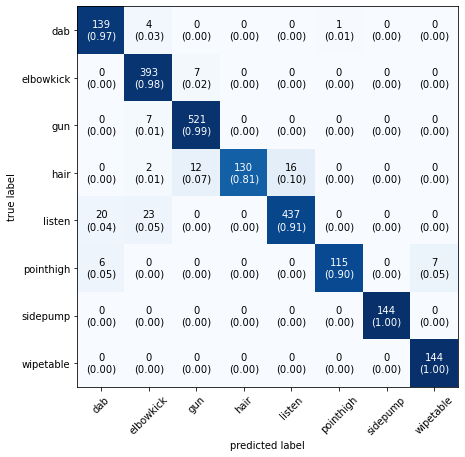

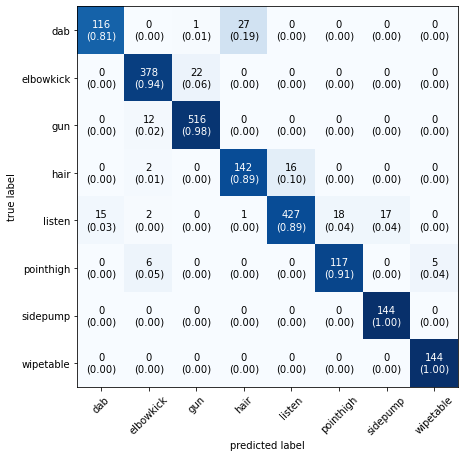

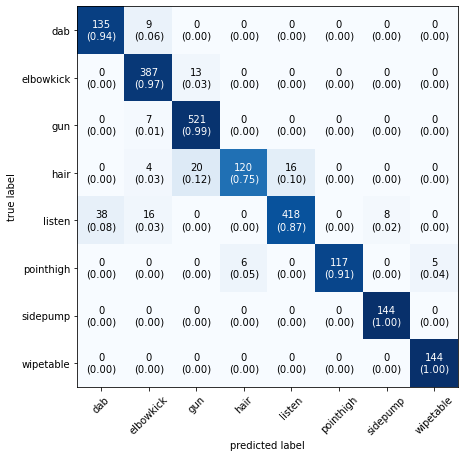

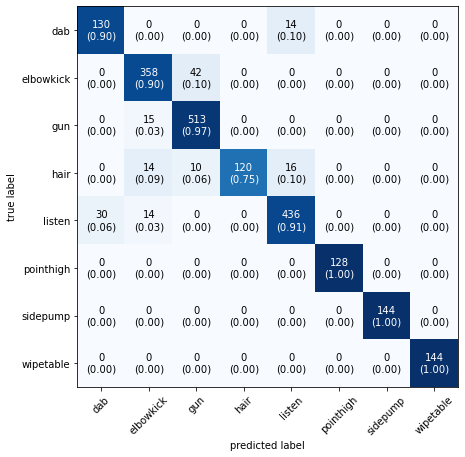

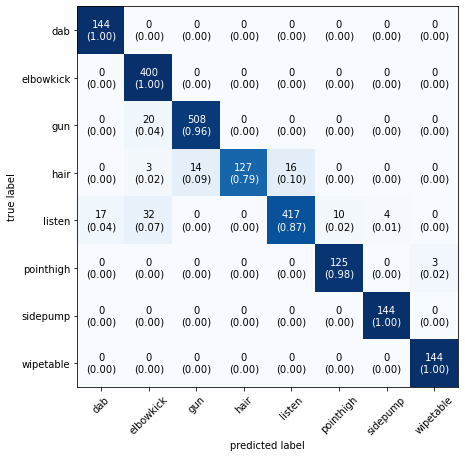

In [29]:
for i in range(5):
    plot_confusion_matrix(conf_mat=cm_hist[i], class_names=encoder.classes_, show_normed=True, 
                          figsize=(7,7), hide_spines=False)

In [30]:
for i in range(5):
    print("\nClassification Report for fold {}:" .format(i+1))
    print(classification_report_hist[i])


Classification Report for fold 1:
              precision    recall  f1-score   support

         dab       0.84      0.97      0.90       144
   elbowkick       0.92      0.98      0.95       400
         gun       0.96      0.99      0.98       528
        hair       1.00      0.81      0.90       160
      listen       0.96      0.91      0.94       480
   pointhigh       0.99      0.90      0.94       128
    sidepump       1.00      1.00      1.00       144
   wipetable       0.95      1.00      0.98       144

    accuracy                           0.95      2128
   macro avg       0.95      0.94      0.95      2128
weighted avg       0.95      0.95      0.95      2128


Classification Report for fold 2:
              precision    recall  f1-score   support

         dab       0.89      0.81      0.84       144
   elbowkick       0.94      0.94      0.94       400
         gun       0.96      0.98      0.97       528
        hair       0.84      0.89      0.86       160
      li

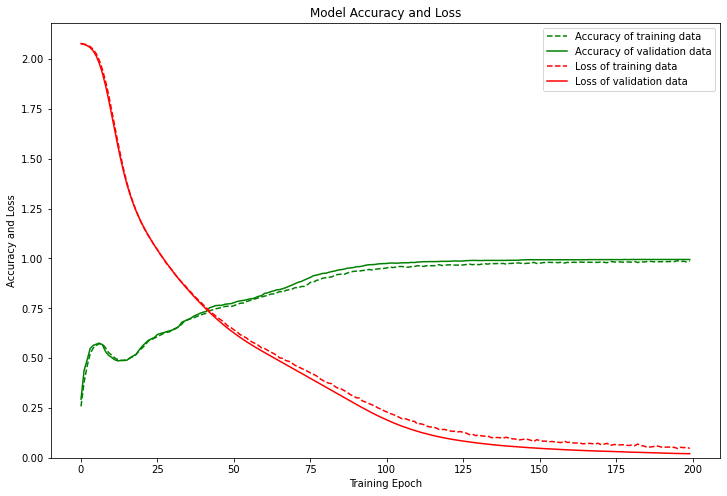

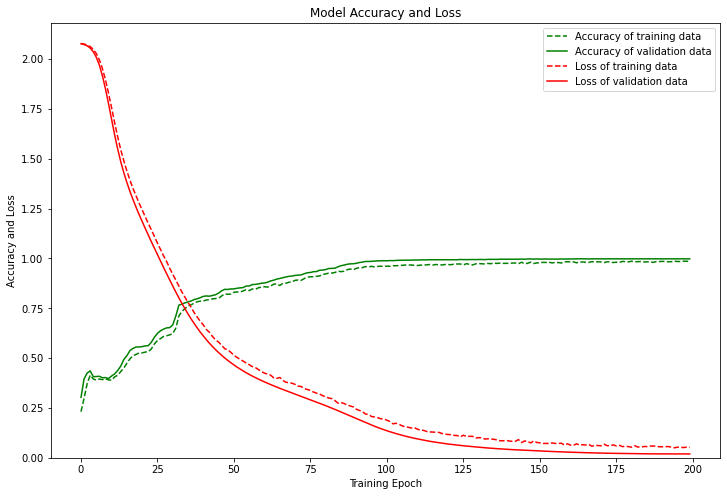

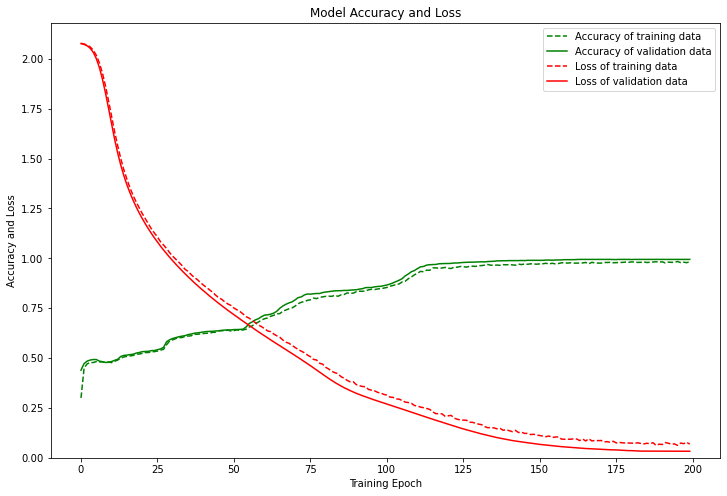

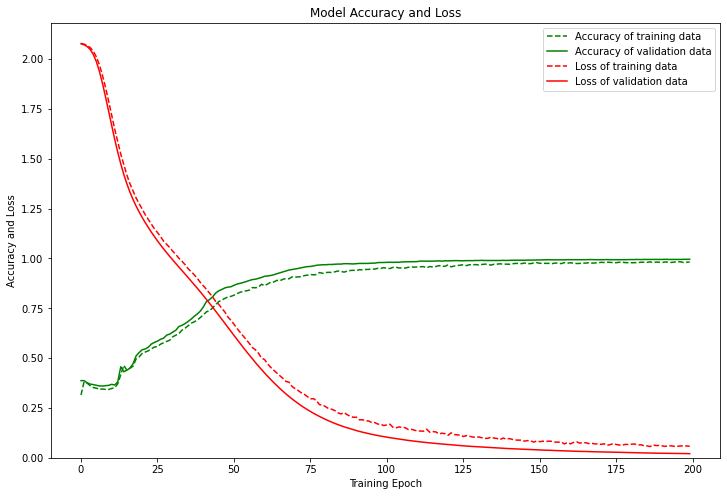

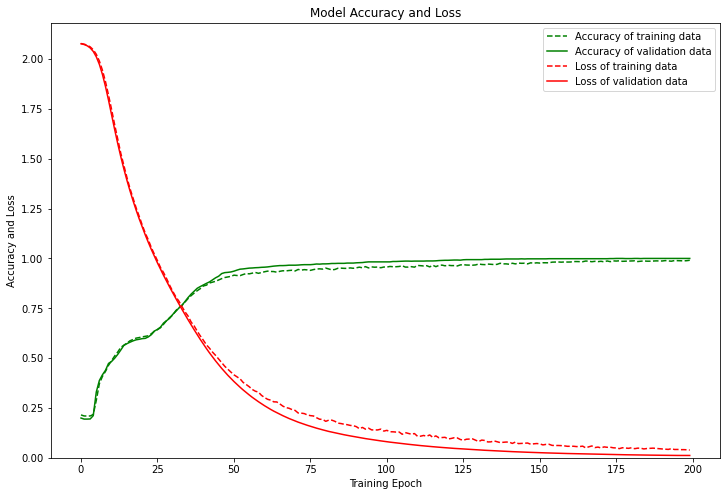

In [31]:
for history in train_histories:
    plt.figure(figsize=(12, 8))
    plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history['loss'], "r--", label="Loss of training data")
    plt.plot(history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()